# 네이버 영화평 감성분석

### 한글  폰트 사용

In [1]:
!apt-get update -qq
!apt-get install fonts-nanum* -qq

Selecting previously unselected package fonts-nanum.
(Reading database ... 160772 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20170925-1_all.deb ...
Unpacking fonts-nanum (20170925-1) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-6_all.deb ...
Unpacking fonts-nanum-eco (1.000-6) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20170925-1_all.deb ...
Unpacking fonts-nanum-extra (20170925-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-1_all.deb ...
Unpacking fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-extra (20170925-1) ...
Setting up fonts-nanum (20170925-1) ...
Setting up fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-eco (1.000-6) ...
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...


In [2]:
# 설치뒤 font-manager rebuild
import matplotlib.font_manager as fm
fm._rebuild()

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rc('font', family='NanumGothic')

### KoNLPy 설치

In [4]:
!pip install Konlpy

     |████████████████████████████████| 19.4MB 1.3MB/s 
     |████████████████████████████████| 450kB 41.8MB/s 
     |████████████████████████████████| 92kB 13.7MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [5]:
import konlpy
konlpy.__version__

'0.5.2'

### 파일 업로드

In [6]:
from google.colab import files
uploaded = files.upload()
filename = list(uploaded.keys())[0]

Saving naver_movie_train.tsv to naver_movie_train.tsv


In [7]:
uploaded = files.upload()
filename = list(uploaded.keys())[0]

Saving naver_movie_test_df.tsv to naver_movie_test_df.tsv


In [8]:
import pandas as pd
train_df = pd.read_csv('naver_movie_train.tsv', sep='\t')
test_df = pd.read_csv('naver_movie_test_df.tsv', sep='\t')
train_df.head(3)

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0


## 한글 형태소 분석

In [9]:
from konlpy.tag import Okt
import tqdm.notebook as tn

In [12]:
okt = Okt()

In [10]:
stopwords = ['은','는','이','가','의','들','좀','잘','걍','과','도','을','를','으로','자','에','와','한','하다']

In [13]:
# X_train
X_train = []
for sentence in tn.tqdm(train_df.document):
    morphs = okt.morphs(sentence, stem=True)
    temp_X = [word for word in morphs if not word in stopwords]
    X_train.append(temp_X)

In [15]:
# X_test
X_test = []

for sentence in tn.tqdm(test_df.document):
    morphs = okt.morphs(sentence, stem=True)
    temp_X = [word for word in morphs if not word in stopwords]
    X_test.append(temp_X)

In [18]:
X_train[:3]

[['아', '더빙', '진짜', '짜증나다', '목소리'],
 ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍다', '않다'],
 ['너', '무재', '밓었', '다그', '래서', '보다', '추천', '다']]

In [20]:
X_test[:3]

[['굳다', 'ㅋ'],
 ['뭐', '야', '평점', '나쁘다', '않다', '점', '짜다', '리', '더', '더욱', '아니다'],
 ['지루하다', '않다', '완전', '막장', '임', '돈', '주다', '보기', '에는']]

### 케라스로 인코딩

In [16]:
import numpy as np
import tensorflow as tf
seed = 2021
np.random.seed(seed)
tf.random.set_seed(seed)

In [17]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Conv1D, Dropout, MaxPooling1D

In [23]:
from keras.preprocessing.text import Tokenizer

In [25]:
max_words = 30000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [26]:
# 전체 데이터의 길이 분포
print('리뷰 최대 길이:', max(len(l) for l in X_train))
print('리뷰 평균 길이:', sum(len(l) for l in X_train) / len(X_train))

리뷰 최대 길이: 69
리뷰 평균 길이: 10.717657468568019


In [27]:
# 샘플의 길이를 30으로 셋팅
max_len = 30
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [28]:
y_train = train_df.label.values
y_test = test_df.label.values

### 1. LSTM 모델 정의/설정/학습/평가

In [29]:
model = Sequential([
                    Embedding(max_words, 100),
                    LSTM(128),
                    Dense(1, activation='sigmoid')
])

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         3000000   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 3,117,377
Trainable params: 3,117,377
Non-trainable params: 0
_________________________________________________________________


In [31]:
model.compile(optimizer = 'adam', loss='binary_crossentropy', metrics = ['accuracy'])

In [33]:
mc = ModelCheckpoint('naver-lstm-best-model.h5', save_best_only=True)

In [34]:
history = model.fit(X_train, y_train, validation_split=0.2, batch_size = 60, epochs=4, callbacks=[mc])

Epoch 1/4
1944/1944 [==============================] - 70s 31ms/step - loss: 0.3873 - accuracy: 0.8230 - val_loss: 0.3497 - val_accuracy: 0.8471
Epoch 2/4
1944/1944 [==============================] - 59s 30ms/step - loss: 0.2922 - accuracy: 0.8749 - val_loss: 0.3414 - val_accuracy: 0.8527
Epoch 3/4
1944/1944 [==============================] - 58s 30ms/step - loss: 0.2373 - accuracy: 0.9014 - val_loss: 0.3799 - val_accuracy: 0.8481
Epoch 4/4
1944/1944 [==============================] - 58s 30ms/step - loss: 0.1917 - accuracy: 0.9214 - val_loss: 0.4082 - val_accuracy: 0.8462


In [36]:
best_model = load_model('naver-lstm-best-model.h5')
best_model.evaluate(X_test, y_test)

1532/1532 [==============================] - 5s 3ms/step - loss: 0.3485 - accuracy: 0.8478


[0.3485334515571594, 0.8478212356567383]

## 학습과정 시각화

In [37]:
y_acc = history.history['accuracy']
y_vacc = history.history['val_accuracy']
y_loss = history.history['loss']
y_vloss = history.history['val_loss']
x_len = np.arange(1, len(y_acc)+1)

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


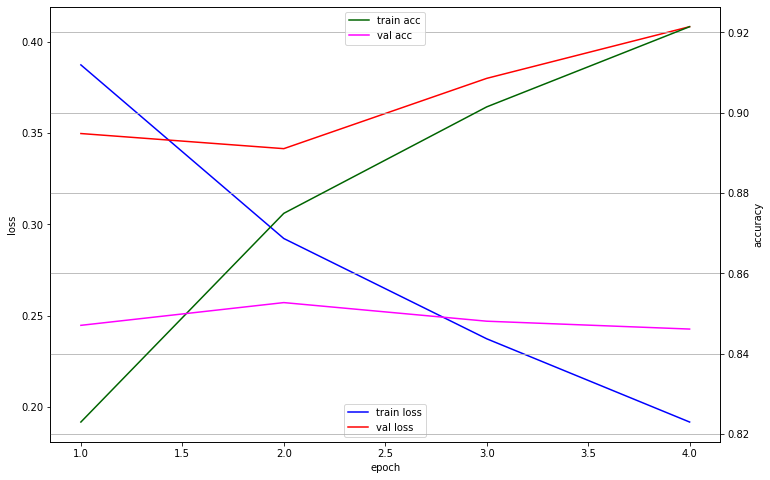

In [38]:
fig, ax0 = plt.subplots(figsize=(12,8))
ax1 = ax0.twinx()

ax0.plot(x_len, y_loss, c='blue', label='train loss')
ax0.plot(x_len, y_vloss, c='red', label='val loss')
ax0.set_ylabel('loss')

ax1.plot(x_len, y_acc, c='darkgreen', label='train acc')
ax1.plot(x_len, y_vacc, c='magenta', label='val acc')
ax1.set_ylabel('accuracy')

ax0.set_xlabel('epoch')
ax0.legend(loc='lower center'); ax1.legend(loc='upper center')
plt.grid(); plt.show()